# Test the new classes for storing and querying GP samples.

## Setup

In [1]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import load, munge
import src.models.gp

In [4]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

## Load data.

### Load matches.

In [5]:
matches = load.all_matches_df()

In [6]:
matches_ti9 = matches.loc[matches.league_name == "The International 2019"]
matches_ti9.shape

(268, 15)

In [7]:
players_mat_ti9 = munge.make_match_players_matrix(
    matches_ti9.radiant_players, matches_ti9.dire_players)
players_mat_ti9.shape

(268, 240)

### Load players.

In [8]:
players = munge.player_id_to_player_name(
    pd.concat([matches_ti9.radiant_players, matches_ti9.dire_players]),
    pd.concat([matches_ti9.radiant_nicknames, matches_ti9.dire_nicknames]),
    pd.concat([matches_ti9.radiant_valveId, matches_ti9.dire_valveId]),
    pd.concat([matches_ti9.radiant_name, matches_ti9.dire_name]),)

In [9]:
players.loc[players_mat_ti9.columns[:5]]

,name,team,team_id
3916428,EGM,Bald,7237270
3940262,March,Team Jinesbrus,7225724
4281729,syndereN,Anti-MagE-,7247587
6922000,pieliedie,Forward Gaming,6214538
10366616,Sneyking,Forward Gaming,6214538


## Make sure the model still runs as before, with initialisation at 0.

In [10]:
two_years_in_ms = 2 * 365 * 24 * 60 * 60 * 1000

In [68]:
import importlib
importlib.reload(src.load)
importlib.reload(src.munge)
importlib.reload(src.models.gp)

<module 'src.models.gp' from '/Users/yl3/github/dota2/src/models/gp.py'>

In [69]:
gp = src.models.gp.SkillsGP(
    players_mat_ti9,
    matches_ti9.startTimestamp.values,
    matches_ti9.radiantVictory,
    players.loc[players_mat.columns].name,
    "exponential",
    {"scale": two_years_in_ms},
    propose_sd=0.1,
    radi_prior_sd=100,  # Non-informative prior
    logistic_scale=1,
    save_every_n_iter=10
)

In [89]:
gp.player_ids = players.loc[players_mat_ti9.columns].name
gp.samples.players = players.loc[players_mat_ti9.columns].name

### Fit numerically using Newton-CG.

In [71]:
res = gp.fit()

Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Iteration.
Optimization terminated successfully.
         Current function value: -7251.013163
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 33
         Hessian evaluations: 2143


In [72]:
res

     fun: -7251.013162613049
     jac: array([-7.49248669e-06, -5.58854939e-06, -4.81143607e-06, ...,
        6.54951929e-06,  1.22494796e-05,  6.39508956e-06])
 message: 'Optimization terminated successfully.'
    nfev: 18
    nhev: 2143
     nit: 16
    njev: 33
  status: 0
 success: True
       x: array([-0.28622648, -0.28618456, -0.28613564, ..., -0.16674437,
       -0.16678097, -0.08426547])

Check radiant advantage:

In [124]:
src.models.gp.win_prob(res.x[-1], 1)

0.47894608824500307

In [82]:
skills_by_player = [res.x[start:end]
                    for start, end in gp.samples.skill_vec_idx_of_player]
skills_by_player[-1]

array([-0.16469036, -0.16480313, -0.16502256, -0.16655581, -0.1666591 ,
       -0.16674437, -0.16678097])

In [83]:
gp.samples.add_sample(-1, skills_by_player, res.x[-1], res.fun)

In [90]:
sample_set = gp.samples

### `GPSampleSet.player_skill_by_sample()`

In [95]:
player_skill_by_sample = sample_set.player_skill_by_sample("pieliedie", [-1])

In [96]:
player_skill_by_sample

matchId,4904311356,4904261164,4904218149,4904171017,4901998619,4901925673,4901799568,4901733286,4899990684,4899794936,4898286553,4898190830,4898118360,4898062038,4897799006
iter,,,,,,,,,,,,,,,
-1,0.596079,0.596095,0.596085,0.596053,0.597558,0.597604,0.59766,0.597679,0.597987,0.597986,0.597966,0.597947,0.597929,0.597918,0.597868


In [97]:
player_skill_by_sample.shape

(1, 15)

### Average skill of player across matches and samples.

In [99]:
skills_by_player = pd.Series(
    [np.mean(sample_set.player_skill_by_sample(player, [-1]).values)
     for player in sample_set.players.index],
    index=sample_set.players.index,
    name="skill")
print(skills_by_player.sort_values(ascending=False).to_string())

6922000      0.597361
86726887     0.597361
221666230    0.597361
108452107    0.597361
10366616     0.597361
153836240    0.403248
157989498    0.403248
119631156    0.403248
292921272    0.403248
164685175    0.403248
86725175     0.305310
84429681     0.305310
94786276     0.305310
87177591     0.305310
87196890     0.305310
72312627     0.259674
87382579     0.259674
169025618    0.259674
142139318    0.259674
98172857     0.259674
277742444    0.250589
342340720    0.250589
137129583    0.250589
163587550    0.250589
107081378    0.250589
234237646    0.248923
94004717     0.248923
87063175     0.248923
105045291    0.248923
85937380     0.248923
127565532    0.244829
480412663    0.244829
107023378    0.244829
99155835     0.244829
90324740     0.244829
86715129     0.240214
31818853     0.240214
131706718    0.240214
115141430    0.240214
349310876    0.240214
119576842    0.218784
139822354    0.218784
186627166    0.218784
89423756     0.218784
148215639    0.218784
412753955 

In [100]:
team_skills = (players.assign(skill=skills_by_player)
               .sort_values("skill")
               .groupby("team").agg({"skill": "sum"})
               .sort_values("skill", ascending=False))
team_skills

,skill
team,
Forward Gaming,2.986805
Infamous Gaming,2.016241
J.Storm,1.526552
Chaos Esports Club,1.298370
CDEC,1.252944
paiN Gaming,1.244613
Vega Squadron,1.224145
beastcoast,1.201069
Royal Never Give Up,1.093920


In [108]:
upper = np.triu(squareform(pdist(team_skills, metric=lambda x, y: 1 / (1 + np.exp((y - x))))))
lower = np.tril(squareform(pdist(team_skills, metric=lambda x, y: 1 / (1 + np.exp((x - y))))))

pd.DataFrame(
    upper + lower,
    index=team_skills.index,
    columns=team_skills.index).iloc[:15, :15]

team,Forward Gaming,Infamous Gaming,J.Storm,Chaos Esports Club,CDEC,paiN Gaming,Vega Squadron,beastcoast,Royal Never Give Up,Mineski,Natus Vincere,Team Jinesbrus,The Final Tribe,Hippomaniacs,Winstrike Team
team,,,,,,,,,,,,,,,
Forward Gaming,0.000000,0.725232,0.811571,0.844018,0.849906,0.850965,0.853543,0.856404,0.869084,0.871377,0.878095,0.882524,0.899034,0.915805,0.919520
Infamous Gaming,0.274768,0.000000,0.620033,0.672138,0.682069,0.683873,0.688281,0.693210,0.715515,0.719630,0.731835,0.740004,0.771353,0.804728,0.812338
J.Storm,0.188429,0.379967,0.000000,0.556799,0.567978,0.570021,0.575031,0.580660,0.606502,0.611338,0.625805,0.635596,0.673988,0.716348,0.726231
Chaos Esports Club,0.155982,0.327862,0.443201,0.000000,0.511355,0.513436,0.518548,0.524306,0.550935,0.555954,0.571037,0.581301,0.622012,0.667797,0.678612
CDEC,0.150094,0.317931,0.432022,0.488645,0.000000,0.502083,0.507199,0.512966,0.539672,0.544713,0.559875,0.570206,0.611274,0.657644,0.668626
paiN Gaming,0.149035,0.316127,0.429979,0.486564,0.497917,0.000000,0.505117,0.510884,0.537602,0.542646,0.557821,0.568163,0.609293,0.655766,0.666777
Vega Squadron,0.146457,0.311719,0.424969,0.481452,0.492801,0.494883,0.000000,0.505769,0.532510,0.537562,0.552767,0.563134,0.604410,0.651131,0.662214
beastcoast,0.143596,0.306790,0.419340,0.475694,0.487034,0.489116,0.494231,0.000000,0.526762,0.531821,0.547056,0.557449,0.598879,0.645871,0.657033
Royal Never Give Up,0.130916,0.284485,0.393498,0.449065,0.460328,0.462398,0.467490,0.473238,0.000000,0.505077,0.520397,0.530877,0.572889,0.620998,0.632499


### `GPSampleSet.team_skill_by_sample()`

In [117]:
radi_skill = sample_set.team_skill_by_sample().iloc[[-1]]
radi_skill

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
-1,1.529711,2.980477,1.530262,2.980266,1.189661,1.190033,1.329758,0.785899,1.329332,1.328472,...,1.047062,-0.182781,0.987495,-0.182042,1.046438,-0.780892,-1.399753,-0.781093,0.344863,-0.180503


In [116]:
dire_skill = sample_set.team_skill_by_sample("dire").iloc[[-1]]
dire_skill

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
-1,2.980395,1.529935,2.980427,1.530703,1.530612,1.530264,0.785651,1.329623,0.786292,0.587611,...,0.345434,0.275433,-0.292452,-1.399745,0.275238,0.345237,0.275337,-0.29183,0.98793,1.044913


In [119]:
skill_diff_mat = (-radi_skill + dire_skill).sub(
    sample_set.radi_adv_by_sample([-1]), 'rows')
radi_win_prob = 1 / (1 + np.exp(skill_diff_mat))
display(radi_win_prob.shape)
radi_win_prob.mean()

(1, 268)

matchId
4904311356    0.177271
4904261164    0.796778
4904218149    0.177346
4904171017    0.796619
4904062522    0.395269
4903974414    0.395441
4903679968    0.612977
4903566049    0.347967
4903441151    0.612724
4903243468    0.658495
4903157391    0.516036
4903091581    0.304947
4903051772    0.516179
4902924459    0.516190
4902837041    0.516331
4902729928    0.516607
4902576905    0.636197
4902464697    0.325951
4902354217    0.636013
4902186317    0.229738
4902122478    0.738891
4902056634    0.229906
4901998619    0.133437
4901925673    0.133479
4901835876    0.401121
4901799568    0.924753
4901742097    0.401212
4901733286    0.064316
4901728834    0.798126
4901646019    0.176242
                ...   
4890122311    0.292441
4889995626    0.075885
4889981518    0.879931
4889881001    0.549879
4889865830    0.760904
4889722230    0.336780
4889691529    0.415315
4889635707    0.473449
4889610539    0.326719
4889555136    0.612461
4889525518    0.170257
4889502467    0.625174
488

In [122]:
matches_ti9.assign(win_prob=radi_win_prob.iloc[-1]).loc[
    :, ["radiant_name", "dire_name", "win_prob", "radiantVictory"]]

,radiant_name,dire_name,win_prob,radiantVictory
matchId,,,,
4904311356,J.Storm,Forward Gaming,0.177271,False
4904261164,Forward Gaming,J.Storm,0.796778,True
4904218149,J.Storm,Forward Gaming,0.177346,False
4904171017,Forward Gaming,J.Storm,0.796619,False
4904062522,beastcoast,J.Storm,0.395269,False
4903974414,beastcoast,J.Storm,0.395441,False
4903679968,Chaos Esports Club,The Final Tribe,0.612977,True
4903566049,The Final Tribe,Chaos Esports Club,0.347967,False
4903441151,Chaos Esports Club,The Final Tribe,0.612724,True


### `GPSampleSet.radi_adv_by_sample()`

In [446]:
sample_set.radi_adv_by_sample().mean()

-0.22822594222496298

### Win probability computed using `GPSampleSet.radi_win_prob_by_sample()`

In [447]:
win_prob_mat = sample_set.radi_win_prob_by_sample()
display(win_prob_mat.shape)
win_prob_mat

(211, 268)

matchId,4904311356,4904261164,4904218149,4904171017,4904062522,4903974414,4903679968,4903566049,4903441151,4903243468,...,4889163811,4889115579,4889038294,4888974952,4888936676,4888859291,4888772755,4888732113,4888686136,4888646940
iter,,,,,,,,,,,,,,,,,,,,,
1100,0.185639,0.902940,0.187587,0.902971,0.403209,0.403921,0.799711,0.341123,0.795309,0.701667,...,0.673475,0.166913,0.726004,0.531323,0.840091,0.494241,0.189527,0.604231,0.542435,0.051020
1110,0.133212,0.927147,0.131983,0.927191,0.250182,0.252097,0.805655,0.310393,0.801434,0.584188,...,0.685296,0.173330,0.772721,0.785777,0.786671,0.379054,0.067675,0.658175,0.627567,0.070588
1120,0.216881,0.864424,0.217553,0.863084,0.305880,0.307631,0.807594,0.291999,0.803990,0.775788,...,0.755845,0.126596,0.826360,0.786829,0.696412,0.553980,0.046735,0.575386,0.277782,0.076008
1130,0.326753,0.776207,0.328519,0.774616,0.179096,0.180668,0.748928,0.355881,0.746456,0.649330,...,0.868127,0.159732,0.793560,0.726789,0.797377,0.784711,0.079197,0.741707,0.241808,0.058159
1140,0.210796,0.875492,0.209304,0.878563,0.313829,0.309918,0.774905,0.345091,0.775454,0.688300,...,0.833987,0.529541,0.855241,0.911372,0.876979,0.526118,0.119385,0.533211,0.227526,0.175094
1150,0.085688,0.954572,0.085261,0.956504,0.267480,0.265380,0.520094,0.637972,0.525474,0.578528,...,0.904526,0.316021,0.925625,0.925653,0.587157,0.781034,0.044354,0.881219,0.232032,0.310695
1160,0.137169,0.918486,0.138703,0.920393,0.404430,0.404814,0.443094,0.685961,0.452035,0.689826,...,0.751046,0.529743,0.866065,0.962676,0.570236,0.534725,0.050951,0.660151,0.303865,0.535414
1170,0.387207,0.753327,0.388701,0.757676,0.117555,0.117803,0.429119,0.712778,0.434189,0.823281,...,0.306511,0.258257,0.939282,0.916111,0.405611,0.180334,0.039285,0.843254,0.744108,0.408188
1180,0.418580,0.729578,0.420523,0.733416,0.250601,0.251814,0.726856,0.414995,0.729447,0.938179,...,0.462624,0.420096,0.857578,0.913007,0.724049,0.285976,0.079038,0.779632,0.726903,0.270083


In [448]:
matches_ti9.assign(win_prob=win_prob_mat.mean()).loc[
    :, ["radiant_name", "dire_name", "win_prob", "radiantVictory"]]

,radiant_name,dire_name,win_prob,radiantVictory
matchId,,,,
4904311356,J.Storm,Forward Gaming,0.172201,False
4904261164,Forward Gaming,J.Storm,0.762482,True
4904218149,J.Storm,Forward Gaming,0.167757,False
4904171017,Forward Gaming,J.Storm,0.766970,False
4904062522,beastcoast,J.Storm,0.384107,False
4903974414,beastcoast,J.Storm,0.382757,False
4903679968,Chaos Esports Club,The Final Tribe,0.602441,True
4903566049,The Final Tribe,Chaos Esports Club,0.304113,False
4903441151,Chaos Esports Club,The Final Tribe,0.605972,True


## What is the autocorrelation between match win probabilities?

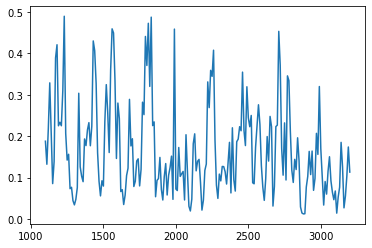

In [539]:
plt.plot(win_prob_mat.iloc[:, 2])

In [516]:
win_prob_autocorr = win_prob_mat.apply(
    lambda x: [x.autocorr(k) for k in range(20)], result_type='expand')

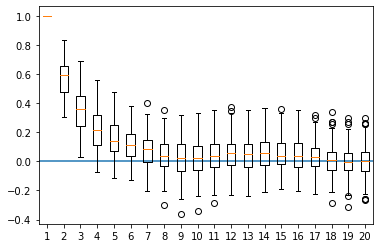

In [527]:
_ = plt.boxplot(win_prob_autocorr)
plt.axhline(0, zorder=0)

Seems like at a lag of 8 dozens of iterations (i.e. 80 individual interations), there is no autocorrelation left.

## What is the Radiant win probability estimate between the most recent sets of samples?

In [455]:
first_match_win_probs = win_prob_mat.iloc[-200:-100].mean()
first_match_win_probs

matchId
4904311356    0.177946
4904261164    0.778724
4904218149    0.173007
4904171017    0.785697
4904062522    0.372651
4903974414    0.371932
4903679968    0.582420
4903566049    0.344112
4903441151    0.591455
4903243468    0.653394
4903157391    0.500188
4903091581    0.287498
4903051772    0.499962
4902924459    0.501110
4902837041    0.502888
4902729928    0.500625
4902576905    0.621618
4902464697    0.304376
4902354217    0.623569
4902186317    0.267287
4902122478    0.672926
4902056634    0.266270
4901998619    0.126468
4901925673    0.125977
4901835876    0.389301
4901799568    0.913895
4901742097    0.380686
4901733286    0.069306
4901728834    0.786523
4901646019    0.167496
                ...   
4890122311    0.269141
4889995626    0.096240
4889981518    0.812945
4889881001    0.490053
4889865830    0.720168
4889722230    0.274477
4889691529    0.375490
4889635707    0.501996
4889610539    0.294808
4889555136    0.623251
4889525518    0.186625
4889502467    0.662653
488

In [456]:
second_match_win_probs = win_prob_mat.iloc[-100:].mean()
second_match_win_probs

matchId
4904311356    0.159776
4904261164    0.735830
4904218149    0.155296
4904171017    0.738104
4904062522    0.404263
4903974414    0.402075
4903679968    0.616778
4903566049    0.245046
4903441151    0.615096
4903243468    0.632774
4903157391    0.484908
4903091581    0.231051
4903051772    0.478581
4902924459    0.471355
4902837041    0.475420
4902729928    0.476866
4902576905    0.609467
4902464697    0.246141
4902354217    0.609781
4902186317    0.191739
4902122478    0.689564
4902056634    0.190648
4901998619    0.146196
4901925673    0.143207
4901835876    0.382710
4901799568    0.884611
4901742097    0.386569
4901733286    0.062001
4901728834    0.804792
4901646019    0.113490
                ...   
4890122311    0.284768
4889995626    0.050852
4889981518    0.880733
4889881001    0.531771
4889865830    0.691135
4889722230    0.297149
4889691529    0.375478
4889635707    0.363785
4889610539    0.299574
4889555136    0.588663
4889525518    0.162828
4889502467    0.527517
488

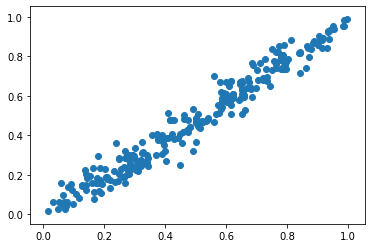

In [460]:
plt.scatter(first_match_win_probs, second_match_win_probs)

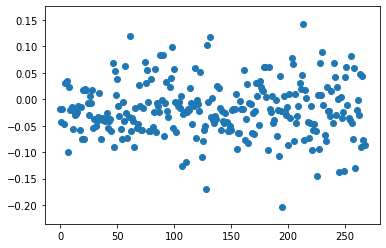

In [459]:
plt.scatter(range(len(first_match_win_probs)),
            second_match_win_probs - first_match_win_probs)